# Comparing Logistic Regressions: Vanilla, Ridge, and Lasso

Pick a dataset of your choice with a binary outcome and the potential for at least 15 features.

Engineer your features, then create three models. Each model will be run on a training set and a test-set (or multiple test-sets, if you take a folds approach). The models should be:

1. Vanilla logistic regression
2. Ridge logistic regression
3. Lasso logistic regression

If you're stuck on how to begin combining your two new modeling skills, here's a hint: the [SKlearn LogisticRegression method]('https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html') has a "penalty" argument that takes either 'l1' or 'l2' as a value.

In your report, evaluate all three models and decide on your best. Be clear about the decisions you made that led to these models (feature selection, regularization parameter selection, model evaluation criteria) and why you think that particular model is the best of the three. Also reflect on the strengths and limitations of regression as a modeling approach. Were there things you couldn't do but you wish you could have done?

Record your work and reflections in a notebook to discuss with your mentor.

In [319]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [320]:
df = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls')
df = df.drop(df.index[0:4]).drop(df.index[-3:])
df.columns = ['city','population','violent_crime','murder','rape_revised','rape_legacy','robbery','agg_assault',
                       'property_crime','burglary','larceny','motor_theft','arson']
df = df.drop('rape_revised', axis=1)
df.index = range(len(df))
df.head()

,city,population,violent_crime,murder,rape_legacy,robbery,agg_assault,property_crime,burglary,larceny,motor_theft,arson
0,Adams Village,1861,0,0,0,0,0,12,2,10,0,0
1,Addison Town and Village,2577,3,0,0,0,3,24,3,20,1,0
2,Akron Village,2846,3,0,0,0,3,16,1,15,0,0
3,Albany,97956,791,8,30,227,526,4090,705,3243,142,NaN
4,Albion Village,6388,23,0,3,4,16,223,53,165,5,NaN


In [321]:
df.shape

(348, 12)

In [322]:
df.isnull().sum()

city                0
population          0
violent_crime       0
murder              0
rape_legacy         0
robbery             0
agg_assault         0
property_crime      0
burglary            0
larceny             0
motor_theft         0
arson             161
dtype: int64

## Choosing the Target (Binary) Variable

In [323]:
df.sum()

city              Adams VillageAddison Town and VillageAkron Vil...
population                                                 13933096
violent_crime                                                 70155
murder                                                          545
rape_legacy                                                    2041
robbery                                                       25370
agg_assault                                                   42199
property_crime                                               275827
burglary                                                      41650
larceny                                                      221682
motor_theft                                                   12495
arson                                                           350
dtype: object

For the target variable, we are interested in predicting when a given city is considered to be among the more dangerous half of the dataset. In order to calculate this, we divided a city's population by its respective violent crime rate because this was the most ubiquitious of values.

In [324]:
foo = df.violent_crime
foo[foo == 0] = 1

crime_to_population = foo / df.population
crime_to_population.median()

target = np.where(crime_to_population > crime_to_population.median(), 1, 0)
target.sum() / len(target)

0.5

In [325]:
crime_to_population.median()

0.0009108303779809183

Now we have a 50/50 distribution of the cities' violent crime rate against its population (where 1 signifies it is among the dangerous half of cities, and 0 signifies it is among the safer half of the documented cities).

## Creation of Features

In [326]:
# Features 1 - 11
features = df.drop('city', axis=1)
features = features.fillna(0)
features['target'] = target

# Features 12 - 15
foo = pd.qcut(features.population, 4, labels=["smallest", "small", "large", "largest"])
features['city_size'] = foo
features = pd.get_dummies(features)

print('Percentage of dangerous within smallest cities: \t' + str(features.target[features.city_size_smallest == 1].mean()))
print('Percentage of dangerous within small cities: \t\t' + str(features.target[features.city_size_small == 1].mean()))
print('Percentage of dangerous within large cities: \t\t' + str(features.target[features.city_size_large == 1].mean()))
print('Percentage of dangerous within largest cities: \t\t' + str(features.target[features.city_size_largest == 1].mean()))

Percentage of dangerous within smallest cities: 	0.45977011494252873
Percentage of dangerous within small cities: 		0.5057471264367817
Percentage of dangerous within large cities: 		0.45977011494252873
Percentage of dangerous within largest cities: 		0.5747126436781609


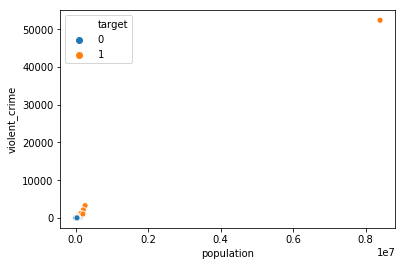

In [327]:
sns.scatterplot(features.population, features.violent_crime, hue=features.target)
plt.show()

In [328]:
# Feature 16
features['pop_squared'] = features.population ** 2

# Feature 17
features['arson_categorical'] = np.where(features.arson > 0, 1, 0)
print('Percentage of dangerous within arson cities: \t\t' + str(features.target[features.arson_categorical == 1].mean()))
print('Percentage of dangerous within non-arson cities: \t' + str(features.target[features.arson_categorical == 0].mean()))

Percentage of dangerous within arson cities: 		0.7037037037037037
Percentage of dangerous within non-arson cities: 	0.46258503401360546


In [329]:
# Feature 18
features['pop_log'] = features.population.apply(np.log)

In [330]:
# Feature 19
features['murder_categorical'] = np.where(features.murder > 0, 1, 0)
print('Percentage of dangerous within murder cities: \t\t' + str(features.target[features.murder_categorical == 1].mean()))
print('Percentage of dangerous within non-murder cities: \t' + str(features.target[features.murder_categorical == 0].mean()))

Percentage of dangerous within murder cities: 		0.8163265306122449
Percentage of dangerous within non-murder cities: 	0.44816053511705684


In [331]:
import featuretools as ft

In [332]:
es = ft.EntitySet(id = 'crimes')
es = es.entity_from_dataframe(entity_id = 'crimes', dataframe = df.drop('city',axis=1).fillna(0), 
                              make_index = True, index='index')

In [356]:
primitives = ft.primitives.list_primitives()

In [334]:
feature_matrix, feature_defs = ft.dfs(entityset = es, target_entity = 'crimes',
                                      trans_primitives = ['add_numeric', 'multiply_numeric'])

In [335]:
len(feature_matrix.columns)

2211

## Selection of Features
#### with Select K Best

In [336]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [337]:
X = feature_matrix
y = target

In [338]:
features_selectkbest = SelectKBest(score_func=chi2, k=25).fit_transform(X, y)
features_selectkbest.shape

(348, 25)

#### with Extra Trees Classifier

In [339]:
from sklearn.ensemble import ExtraTreesClassifier

In [340]:
model = ExtraTreesClassifier()
model.fit(X, y)
features_trees = pd.DataFrame(model.feature_importances_, columns=['value'])
index_trees = list(features_trees.nlargest(25, 'value').index)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [341]:
features_besttrees = X.iloc[:,index_trees]

## Method A: Train-Test with All Features
### Creating the Train-Test Sets

In [342]:
from sklearn.model_selection import train_test_split

In [343]:
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, target, test_size=.33)

### Model A1: Vanilla Logistic Regression

In [344]:
from sklearn import linear_model

In [345]:
vanilla = linear_model.LogisticRegression(C=1e9)
vanilla_fit = vanilla.fit(X_train, y_train)

print('Coefficients:')
print(vanilla_fit.coef_)
print(vanilla_fit.intercept_)
pred_y_sklearn = vanilla_fit.predict(X_test)

print('\n Accuracy by admission status')
print(pd.crosstab(pred_y_sklearn, y_test))

print('\n Percentage accuracy')
print(vanilla.score(X_test, y_test))

pred_y_sklearn

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Coefficients:
[[-4.112e-17  9.021e-19  9.048e-21 ...  3.664e-18  5.122e-17  7.116e-16]]
[-4.458e-21]

 Accuracy by admission status
col_0   0   1
row_0        
1      49  66

 Percentage accuracy
0.5739130434782609


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1])

### Model A2: Ridge Logistic Regression

In [346]:
# Creating first lambda value for the for-loop list
ridge = linear_model.Ridge(alpha=1, fit_intercept=False)
ridge_fit = ridge.fit(X_train, y_train)
ridge_scores = [1, ridge.score(X_train, y_train)]

# Filling the list with remaining r-squared values that will include lambdas 1-50
for lambd in range(3, 50, 2):
    ridge = linear_model.Ridge(alpha=lambd, fit_intercept=False)
    ridge.fit(X_train, y_train)
    ridge_scores = np.row_stack((ridge_scores, np.append(lambd, ridge.score(X_train, y_train))))
    
ridge_scores = pd.DataFrame(ridge_scores, columns=['Lambda','R-Squared'])

ridge_scores[ridge_scores['R-Squared'] == ridge_scores['R-Squared'].max()]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linea

,Lambda,R-Squared
3,7.0,-0.65293


In [347]:
pred_y_ridge = ridge_fit.predict(X_test)

print('\n Percentage accuracy')
print(ridge.score(X_test, y_test))


 Percentage accuracy
-5.565868770446953


### Model A3: Lasso Logistic Regression

In [348]:
# Creating first lambda value for the for-loop list
lasso = linear_model.Lasso(alpha=.01)
lasso.fit(X_train, y_train)
lasso_scores = [.01, lasso.score(X_train, y_train)]

# Filling the list with remaining r-squared values that will include lambdas 1-50
for lambd in np.arange(.03, .50, .02):
    lasso = linear_model.Lasso(alpha=lambd, fit_intercept=False)
    lasso.fit(X_train, y_train)
    lasso_scores = np.row_stack((lasso_scores, np.append(lambd, lasso.score(X_test, y_test))))

lasso_scores = pd.DataFrame(lasso_scores, columns=['Lambda','R-Squared'])

lasso_scores[lasso_scores['R-Squared'] == lasso_scores['R-Squared'].max()]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

,Lambda,R-Squared
0,0.01,0.174546


## Method B: Train-Test with Top 25 SelectKBest Features
### Creating the Train-Test Sets

In [349]:
X_train, X_test, y_train, y_test = train_test_split(features_selectkbest, target, test_size=.33)

### Model B1: Vanilla Logistic Regression

In [350]:
from sklearn import linear_model

In [351]:
vanilla = linear_model.LogisticRegression(C=1e9)
vanilla_fit = vanilla.fit(X_train, y_train)

print('Coefficients:')
print(vanilla_fit.coef_)
print(vanilla_fit.intercept_)
pred_y_sklearn = vanilla_fit.predict(X_test)

print('\n Accuracy by admission status')
print(pd.crosstab(pred_y_sklearn, y_test))

print('\n Percentage accuracy')
print(vanilla.score(X_test, y_test))

pred_y_sklearn

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Coefficients:
[[2.977e-12 2.934e-12 2.958e-12 2.885e-12 2.997e-12 2.945e-12 2.880e-12
  2.893e-12 2.911e-12 2.987e-12 2.949e-12 3.010e-12 2.870e-12 2.934e-12
  2.986e-12 3.030e-12 2.987e-12 3.028e-12 2.871e-12 2.988e-12 2.976e-12
  3.096e-12 2.935e-12 3.002e-12 2.935e-12]]
[-1.276e-21]

 Accuracy by admission status
col_0   0   1
row_0        
1      52  63

 Percentage accuracy
0.5478260869565217


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1])

### Model B2: Ridge Logistic Regression

In [352]:
# Creating first lambda value for the for-loop list
ridge = linear_model.Ridge(alpha=1, fit_intercept=False)
ridge_fit = ridge.fit(X_train, y_train)
ridge_scores = [1, ridge.score(X_train, y_train)]

# Filling the list with remaining r-squared values that will include lambdas 1-50
for lambd in range(3, 50, 2):
    ridge = linear_model.Ridge(alpha=lambd, fit_intercept=False)
    ridge.fit(X_train, y_train)
    ridge_scores = np.row_stack((ridge_scores, np.append(lambd, ridge.score(X_train, y_train))))
    
ridge_scores = pd.DataFrame(ridge_scores, columns=['Lambda','R-Squared'])

ridge_scores[ridge_scores['R-Squared'] == ridge_scores['R-Squared'].max()]

,Lambda,R-Squared
0,1.0,-0.447453


In [353]:
pred_y_ridge = ridge_fit.predict(X_test)

print('\n Percentage accuracy')
print(ridge.score(X_test, y_test))


 Percentage accuracy
-1909.1000417443297


### Model B3: Lasso Logistic Regression

In [354]:
# Creating first lambda value for the for-loop list
lasso = linear_model.Lasso(alpha=.01)
lasso.fit(X_train, y_train)
lasso_scores = [.01, lasso.score(X_train, y_train)]

# Filling the list with remaining r-squared values that will include lambdas 1-50
for lambd in np.arange(.03, .50, .02):
    lasso = linear_model.Lasso(alpha=lambd, fit_intercept=False)
    lasso.fit(X_train, y_train)
    lasso_scores = np.row_stack((lasso_scores, np.append(lambd, lasso.score(X_test, y_test))))

lasso_scores = pd.DataFrame(lasso_scores, columns=['Lambda','R-Squared'])

lasso_scores[lasso_scores['R-Squared'] == lasso_scores['R-Squared'].max()]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

,Lambda,R-Squared
0,0.01,0.004753


## Method B: Train-Test with Top 25 Tree Classifier Features
### Creating the Train-Test Sets

In [357]:
X_train, X_test, y_train, y_test = train_test_split(features_besttrees, target, test_size=.33)

### Model C1: Vanilla Logistic Regression

In [358]:
from sklearn import linear_model

In [359]:
vanilla = linear_model.LogisticRegression(C=1e9)
vanilla_fit = vanilla.fit(X_train, y_train)

print('Coefficients:')
print(vanilla_fit.coef_)
print(vanilla_fit.intercept_)
pred_y_sklearn = vanilla_fit.predict(X_test)

print('\n Accuracy by admission status')
print(pd.crosstab(pred_y_sklearn, y_test))

print('\n Percentage accuracy')
print(vanilla.score(X_test, y_test))

pred_y_sklearn

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Coefficients:
[[1.240e-14 8.773e-17 4.180e-14 1.286e-14 2.764e-14 4.971e-11 6.016e-11
  3.050e-14 9.083e-12 2.015e-13 8.246e-17 1.961e-13 5.523e-14 1.922e-14
  1.334e-16 4.225e-14 2.101e-11 1.888e-14 1.486e-11 1.129e-11 1.839e-13
  2.542e-11 2.508e-14 4.362e-12 1.537e-15]]
[-3.139e-19]

 Accuracy by admission status
col_0   0   1
row_0        
1      55  60

 Percentage accuracy
0.5217391304347826


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1])

### Model C2: Ridge Logistic Regression

In [360]:
# Creating first lambda value for the for-loop list
ridge = linear_model.Ridge(alpha=1, fit_intercept=False)
ridge_fit = ridge.fit(X_train, y_train)
ridge_scores = [1, ridge.score(X_train, y_train)]

# Filling the list with remaining r-squared values that will include lambdas 1-50
for lambd in range(3, 50, 2):
    ridge = linear_model.Ridge(alpha=lambd, fit_intercept=False)
    ridge.fit(X_train, y_train)
    ridge_scores = np.row_stack((ridge_scores, np.append(lambd, ridge.score(X_train, y_train))))
    
ridge_scores = pd.DataFrame(ridge_scores, columns=['Lambda','R-Squared'])

ridge_scores[ridge_scores['R-Squared'] == ridge_scores['R-Squared'].max()]

,Lambda,R-Squared
0,1.0,0.194576


In [361]:
pred_y_ridge = ridge_fit.predict(X_test)

print('\n Percentage accuracy')
print(ridge.score(X_test, y_test))


 Percentage accuracy
-3569.1639024132896


### Model C3: Lasso Logistic Regression

In [362]:
# Creating first lambda value for the for-loop list
lasso = linear_model.Lasso(alpha=.01)
lasso.fit(X_train, y_train)
lasso_scores = [.01, lasso.score(X_train, y_train)]

# Filling the list with remaining r-squared values that will include lambdas 1-50
for lambd in np.arange(.03, .50, .02):
    lasso = linear_model.Lasso(alpha=lambd, fit_intercept=False)
    lasso.fit(X_train, y_train)
    lasso_scores = np.row_stack((lasso_scores, np.append(lambd, lasso.score(X_test, y_test))))

lasso_scores = pd.DataFrame(lasso_scores, columns=['Lambda','R-Squared'])

lasso_scores[lasso_scores['R-Squared'] == lasso_scores['R-Squared'].max()]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

,Lambda,R-Squared
0,0.01,0.035331
